<a href="https://colab.research.google.com/github/priyank766/Multimodel_RAG/blob/main/MedicalRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB

In [2]:
!pip install langchain unstructured[all-docs] pydantic lxml faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 4.9 MB/s eta 0:00:0

In [3]:
!pip install google-generativeai

In [4]:
!pip install langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [5]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.4 MB/s eta 0:00:00


In [6]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage,SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [7]:
from google.colab import userdata
google_api_key = userdata.get('GOOGLE_API_KEY')

In [8]:
output_path="./images"

In [9]:
raw_pdf_elements = partition_pdf(
    filename="/content/AC-Aids-for-Dogs_Canine-Periodontal-Disease_0.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars= 35,
    combiner_text_n_chars= 2000,
    extract_image_block_output_dir=output_path
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [10]:
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatGoogleGenerativeAI(model="gemini-2.5-pro",api_key=google_api_key),
    prompt=PromptTemplate.from_template(summary_prompt)
)

/tmp/ipython-input-2905764710.py:11: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summary_chain = LLMChain(


In [11]:
for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

/tmp/ipython-input-2749957104.py:4: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summary_chain.run({'element_type': 'text', 'element': e})


In [12]:
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to Dog's health."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatGoogleGenerativeAI(model="gemini-2.5-flash",api_key=google_api_key).invoke(prompt)
    return response.content

In [13]:
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [14]:
!pip install faiss-cpu

In [15]:
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001",google_api_key=google_api_key))

vectorstore.save_local("faiss_index")

In [16]:
embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001",google_api_key=google_api_key)

In [19]:
database=FAISS.load_local("faiss_index",embedding, allow_dangerous_deserialization=True)

In [20]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [21]:
qa_chain = LLMChain(llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash",api_key=google_api_key),
                        prompt=PromptTemplate.from_template(prompt_template))

In [22]:
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

Gingivitis is the inflammation of the gums, which occurs when tartar irritates the gums. It is characterized by redness and inflammation at the gumline. If left untreated, the tartar builds up under the gum line, resulting in Periodontal Disease (PD).


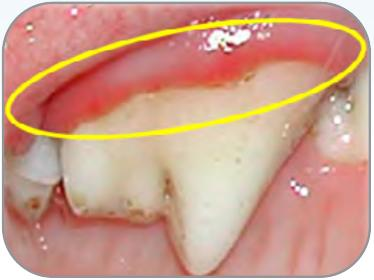

In [23]:
result, relevant_images = answer("What is Gingivitis?")
print(result)

relevant_images[0]

display.display(display.Image(base64.b64decode(relevant_images[0])))